# Experimental Setup & First Look

We have downloaded the **Enquête emploi en continu 2015** database from the [INSEE website](https://www.insee.fr/fr/statistiques/2388681). The database is in dBASE format (`.dbf`, 80mb), compressed into a ZIP file (`.zip`, 9mb).

The `.zip` file contains three dBASE files:
   - `eec15.dbf` (77MB)
   - `varlist.dbf` (33KB)
   - `varmod.dbf` (33KB)

Because the dBASE format is inconvenient to work with, we import the contents of these three files into an SQLite databases using the [`dbf2sqlite`](https://github.com/olemb/dbfread/blob/master/examples/dbf2sqlite) script, with the following command:

    ./dbf2sqlite --encoding=cp850 -o ee-insee-2015.sqlite eec15.dbf varlist.dbf varmod.dbf

## Experimental Setup

### Libraries & Settings

In [1]:
import os              # General OS commands
import numpy as np     # NumPy
import pandas as pd    # Python Data Analysis Library
import zipfile         # Compress/decompress ZIP files
import sqlite3         # SQLite3 Database Driver

import matplotlib.pyplot as plt
# Display MatPlotLib stuff inline
%matplotlib inline

In [2]:
# Never truncate columns, display all the data
from IPython.display import display, HTML
pd.set_option('display.max_colwidth', -1)

# Display floating-point numbers with 4 decimals in `pandas.DataFrame`
pd.options.display.float_format = '{:,.4f}'.format

### Helpers

In [3]:
# Helper function to display nice dictionaries in HTML
def HTMLIter(iter_):
    items = iter_ if isinstance(iter_, list) else iter_.iteritems()
    html = []
    for key, value in items:
        html.append("<tr>")
        html.append("<td><strong>{0}</strong></td>".format(key))
        html.append("<td>{0}</td>".format(value))
        html.append("</tr>")
    html.append("</table>")
    return HTML(''.join(html))

# Temporary files to delete at the end of the experiment
temp_files = []

### Database

The resulting SQLite database weighs about 89MB, which is too large for GitHub (our version control repository), so we compressed the database and decompress it on-the-fly before each experiment.

In [4]:
zip_filename = "../data/ee-insee-2015-sqlite.zip"
with zipfile.ZipFile(zip_filename) as zip_file:
    zip_file.extractall("../data/")

eedb = zip_filename.replace("-sqlite.zip", ".sqlite")
temp_files.append(eedb)

## First look

### Variables
We first look at the list of variables to find out what kind of data we have access to. The variables (i.e. the columns of the main table `eec15`) and their labels are stored in the `varlist` table.

In [5]:
with sqlite3.connect(eedb) as con:
    query = "SELECT * FROM varlist"
    df = pd.read_sql_query(query, con)

df.columns = ["Variable", "Libellé"]
HTML(df.to_html(index=False))

Variable,Libellé
AAC,"Exercice d'une activité professionnelle régulière antérieure, pour les inactifs, chômeurs et personnes ayant une activité temporaire ou d'appoint autre qu'un emploi informel"
ACTEU,Statut d'activité au sens du Bureau International du Travail (BIT) selon l'interprétation communautaire
ACTEU6,Statut d'activité au sens du Bureau International du Travail (BIT) selon l'interprétation communautaire (6 postes)
ACTIF,Actif au sens du BIT
ACTOP,Actif occupé au sens du Bureau International du Travail (BIT)
AGE3,"Âge au dernier jour de la semaine de référence (3 postes, premier type de regroupement)"
AGE5,Âge au dernier jour de la semaine de référence (5 postes)
AIDFAM,Aide familial ou conjoint collaborateur
ANCCHOM,Ancienneté de chômage en 8 postes
ANCENTR4,Ancienneté dans l'entreprise ou dans la fonction publique (4 postes)


### Survey Data
We first load the `eec15` table into a `pandas` DataFrame for easier manipulation.

In [6]:
with sqlite3.connect(eedb) as con:
    eec15 = pd.read_sql("SELECT * FROM eec15", con)

We look at the actual survey data to get an idea of how much data we are dealing with, and what this data looks like.

In [7]:
HTMLIter([
    ("Observations", eec15.shape[0]),
    ("Men", eec15[eec15.sexe == "1"].shape[0]),
    ("Women", eec15[eec15.sexe == "2"].shape[0]),
    ("Parameters", eec15.shape[1])
])

Observations,431678
Men,203516
Women,228162
Parameters,125


In [8]:
eec15.head()

,annee,trim,catau2010r,metrodom,typmen7,age3,age5,coured,enfred,nfrred,...,dip11,cstotprm,identm,extrian16,empnbh,hrec,hhce,hplusa,jourtr,nbtote
0,2015,2,1,1,4,30,30,1,1,1,...,71,53,1,127.0832,37.0000,nan,37.0000,nan,5.0000,nan
1,2015,2,1,1,4,15,15,1,1,1,...,42,53,1,127.0832,nan,nan,nan,nan,nan,nan
2,2015,2,1,1,1,15,15,2,2,1,...,10,54,2,133.2541,nan,nan,36.0000,nan,5.0000,nan
3,2015,3,1,1,1,15,15,2,2,1,...,10,54,3,141.9700,nan,nan,36.0000,39.0000,5.0000,nan
4,2015,4,1,1,1,15,15,2,2,1,...,10,54,4,136.1817,36.0000,nan,36.0000,40.0000,5.0000,nan


## Variable description
As our objective is to model employment/unemployment, we take a deeper look into the variables that are available to us. In particular, we identify some variables of interest that we believe would be appropriate parameters in a regression model.

We then try to summarise these variables through (1) **descriptive statistics** (2) **graphical representation**, which gives us better insights into the variables and what they look like.

### Dependent/explained variable
The objective of our model will be to identify the relationship between **employment status** and some parameters that we will choose from the set of variables in the database. As such, the regressor in our model will be a binary variable **employed/unemployed**.

The database provides us with the following data, so we need to figure out which of these is closest to a simple employed/unemployed binary variable:
- **ACTEU**: *Statut d'activité au sens du Bureau International du Travail (BIT) selon l'interprétation communautaire*
- **ACTEU6**: *Statut d'activité au sens du Bureau International du Travail (BIT) selon l'interprétation communautaire (6 postes)*
- **ACTIF**: *Actif au sens du BIT*
- **ACTOP**: *Actif occupé au sens du BIT*

The possible values for these variables are contained in the `varmod` table and are summarised in the following table (*for simplicity, we choose to ignore **ACTEU6***).

In [9]:
with sqlite3.connect(eedb) as con:
    query = """
        SELECT *
        FROM varmod
        WHERE variable IN ("ACTEU", "ACTIF", "ACTOP")
    """
    df = pd.read_sql_query(query, con)

df.columns = ["Variable", "Modalité", "Libellé"]
HTML(df.to_html(index=False))

Variable,Modalité,Libellé
ACTEU,,"Sans objet (ACTEU non renseigné, individus de 15 ans et plus nécessairement non pondérés)"
ACTEU,1,Actif occupé
ACTEU,2,Chômeur
ACTEU,3,Inactif
ACTIF,,"Sans objet (ACTEU non renseigné, individus de 15 ans et plus nécessairement non pondérés)"
ACTIF,1,Actif
ACTIF,2,Inactif
ACTOP,,"Sans objet (ACTEU non renseigné, individus de 15 ans et plus nécessairement non pondérés)"
ACTOP,1,Oui
ACTOP,2,Non


We can take the opportunity to perform a **sanity check** on the data, to ensure both that the data is consistent, and that we have understood these variables properly. To this end, we use the following identities, inferred from the definitions of the variables contained in the `varlist`/`varmod` tables:
- `ACTOP(1) = ACTEU(1)`
- `ACTOP(2) = ACTEU(2) + ACTEU(3)`
- `ACTIF(1) = ACTEU(1) + ACTEU(2)`
- `ACTIF(2) = ACTEU(3)`

In [10]:
varmods = [("ACTEU", [1, 2, 3]), ("ACTOP", [1, 2]), ("ACTIF", [1, 2])]
varmods = [(v[0], m) for v in varmods for m in v[1]]
counts = {vm: eec15[eec15[vm[0].lower()] == str(vm[1])].shape[0] for vm in varmods}
        
print "ACTOP(1): {} | ACTEU(1): {}".format(counts[("ACTOP", 1)], counts[("ACTEU", 1)])
print "ACTOP(2): {} | ACTEU(2) + ACTEU(3): {}".format(counts[("ACTOP", 2)], sum([counts[("ACTEU", 2)], counts[("ACTEU", 3)]]))
print "ACTIF(1): {} | ACTEU(1) + ACTEU(2): {}".format(counts[("ACTIF", 1)], sum([counts[("ACTEU", 1)], counts[("ACTEU", 2)]]))
print "ACTIF(2): {} | ACTEU(3): {}".format(counts[("ACTIF", 2)], counts[("ACTEU", 3)])

ACTOP(1): 198381 | ACTEU(1): 198379
ACTOP(2): 231995 | ACTEU(2) + ACTEU(3): 231997
ACTIF(1): 223130 | ACTEU(1) + ACTEU(2): 223130
ACTIF(2): 207246 | ACTEU(3): 207246


The sanity check has highlighted some very slight discrepancies. The (small) difference in totals does not *necessarily* mean that only 2 observations are affected: we need to check how many rows are affected and whether this discrepancy can turn out to be problematic.

In [11]:
# Filter the DataFrame to find the problematic rows
masks = [
    (eec15.actop == "1") & (eec15.acteu != "1"),
    (eec15.acteu.isin(["2", "3"]) & ~(eec15.actop == "2"))
]

# Print the index of problematic observations
obs = [list(eec15[mask].index) for mask in masks]
print obs

[[213788, 244700], [213788, 244700]]


The (two) affected rows are the same for both masks, so we can safely conclude that these two observations are problematic, but that the rest of the database is safe. We also remove these two observations from the DataFrame for later analyses.

In [12]:
eec15 = eec15[~eec15.index.isin(obs[0])]

The results of our sanity check are now satisfactory, we choose to use **ACTOP** as our (binary) dependent variable:
- **ACTOP = 1**: the observed individual is part of the *population active occupée*
- **ACTOP = 2**: the observed individual is *chômeur* or *inactif*

### Independent/explanatory variables
We choose a few "basic" variables that we (intuitively) think will be part of our regression models:
- **AGE5**: *Âge au dernier jour de la semaine de référence (5 postes)*
- **DIP11**: *Diplôme le plus élevé obtenu (2 chiffres, 11 postes)*
- **SEXE**: *Masculin/Féminin*
- **TRIM**: *Trimestre de référence de l'enquête*
- **NFRRED**: *Nationalité française ou étrangère*
- **METRODOM**: *Région du logement de résidence en 2 modalités (Métropole vs. DOM)*
- **ENFRED**: *Individu avec au moins un enfant dans le ménage ou en garde alternée, au trimestre courant*
- **CATAU2010R**: *Catégorie de commune du logement de résidence (4 modalités)*

In [13]:
basic = eec15[["actop", "age5", "dip11", "sexe"]].copy()    # create a new df subset of the entire database
basic = basic.replace([""], [None]).dropna()    # drop any rows that have NULL, N/A or empty values
for col in ["actop", "sexe"]:
    basic[col] = basic[col].map({"2": 1, "1": 0})
basic = basic.astype(int)    # convert all data to `int` type

We now look at summary statistics and graphical representations for these variables.

In [14]:
basic.describe()

,actop,age5,dip11,sexe
count,"427,080.0000","427,080.0000","427,080.0000","427,080.0000"
mean,0.5376,42.2708,47.8676,0.5294
std,0.4986,16.7807,19.5421,0.4991
min,0.0000,15.0000,10.0000,0.0000
25%,0.0000,30.0000,41.0000,0.0000
50%,1.0000,50.0000,50.0000,1.0000
75%,1.0000,60.0000,70.0000,1.0000
max,1.0000,60.0000,71.0000,1.0000


Our initial graphical representation simply plots (`param`, `actop`) on a scatter plot. Because `actop` only takes values from `{0, 1}`, the points are superposed and we cannot have an idea of the magnitude/count of `{0, 1}`s.

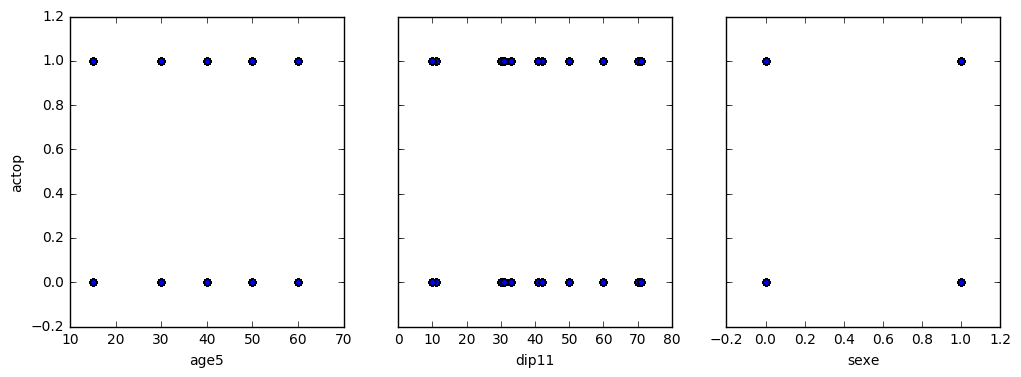

In [15]:
params = [_ for _ in basic.columns if _ != "actop"]
figure, x_axis = plt.subplots(1, len(params), figsize=(12, 4), sharey=True)
for ix, param in enumerate(params):
    basic.plot.scatter(x=param, y="actop", ax=x_axis[ix])

In order to get a better idea of what is going on, we add some "noise" to the `actop` values. We calculate the noise based on the expected value of `actop` conditional on `x` being equal to one of the possible categories, i.e.:

$$P(y=1 | x=k, X_{-1})$$

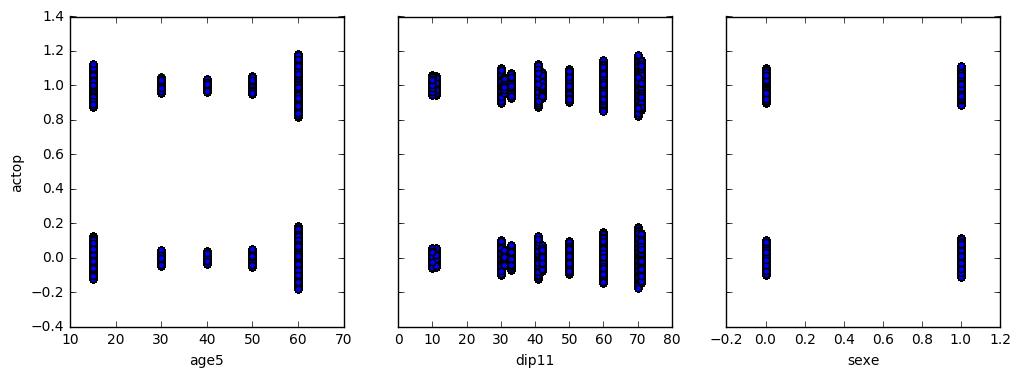

In [16]:
params = [_ for _ in basic.columns if _ != "actop"]
xy = {}

figure, x_axis = plt.subplots(1, len(params), sharey=True, figsize=(12, 4))

# Create a new DataFrame(param, noisy("actop")) for each of the parameters of interest
# and store this DataFrame in the `xy` dictionary.
for ix, param in enumerate(params):
    xy[param] = basic[[param, "actop"]].copy()
    
    # Calculate mean value of `actop` for each `param` category
    # Note: mean(actop) is the probability of employment for a given category
    means = xy[param].groupby(param).mean()

    # Scale down the means to be in [0, 0.2], such that the points
    # are contained in a circle with radius 0.2 around y=0 and y=1
    means *= 0.2

    # Generate a "noise" Series from a uniform distribution with range [-mean, mean]
    # Take the `params` column of observations, map the appropriate mean
    # then apply the `uniform` function to the mean
    meansd = means["actop"].to_dict()
    eps = xy[param][param].map(meansd)
    eps = eps.apply(lambda x: np.random.uniform(-x, x))
    
    # Add the `epsilon` and (original) `actop` vectors
    xy[param]["actop"] += eps

    # For each `param`, we now have a DataFrame that maps `param`-value to `noisy(actop)`,
    # and we are ready to plot the noisy version of the chart, using the `figure` object
    # created above
    xy[param].plot.scatter(x=param, y="actop", ax=x_axis[ix])

## Custom Database

We now build a custom subset of the original `eec15` database and export it in SQL format. The purpose of this is **(1)** to enable other team members to work on a clean & small subset with other languages (e.g. `R`), and **(2)** to perform the work of cleaning the database here once and for all, and enable loading the custom version in separate notebooks.

We perform some transformations and cleaning on the loaded subset. In particular, we:
1. drop any observations that contain any `NULL` or `N/A` values
2. convert all values from generic `object` types to the `int` type (note that `pandas` will automatically cast from `int` to `float` when required)
3. transform the original categorical variables into a set of purely binary variables

**Note**: we keep the original variables and label the transformed (binary) ones with an extra "`_`" (e.g. `dip11` vs. `dip31_`)

In [17]:
# Create a subsetted copy of the original `eec15` DataFrame
params = ["actop", "age5", "dip11", "sexe", "trim", "nfrred", "metrodom", "enfred", "catau2010r"]
eec15_custom = eec15[params].copy()

# Drop any observations that contain any NULL, N/A or empty values
eec15_custom = eec15_custom.replace([""], [None]).dropna()

# Convert all values from generic objects to the `float` type
eec15_custom = eec15_custom.astype(int) 

# Transform categorical variables into a set of purely binary variables
## ACTOP: (1, 2) -> (0, 1)
eec15_custom["actop_"] = eec15_custom["actop"].map({1: 0, 2: 1})

## AGE5: split into AGE{00,15,30,40,50,60}_
for x in list(set(eec15_custom["age5"].get_values())):
    eec15_custom["age{}_".format(x)] = np.where(eec15_custom["age5"] == x, 1, 0)

## DIP11: split into DIP{10,11,30,31,33,41,42,50,60,70,71}_
for x in list(set(eec15_custom["dip11"].get_values())):
    eec15_custom["dip{}_".format(x)] = np.where(eec15_custom["dip11"] == x, 1, 0)

## SEXE: create FEMALE_ = (1,2) -> (0,1), MALE_ = ~FEMALE
eec15_custom["female_"] = eec15_custom["sexe"].map({1: 0, 2: 1})
eec15_custom["male_"] = (~eec15_custom["female_"].astype(bool)).astype(int)

## NFRRED: create ETRANGER_ = ((1, 2), 3) -> (0, 1), FRANCAIS_ = ~ETRANGER
eec15_custom["etranger_"] = eec15_custom["nfrred"].map({1: 0, 2: 0, 3: 1})
eec15_custom["francais_"] = (~eec15_custom["etranger_"].astype(bool)).astype(int)

## METRODOM: create METROPOLE_ = (1, 2) -> (1, 0), DOMTOM_ = ~METROPOLE_
eec15_custom["metropole_"] = eec15_custom["metrodom"].map({1: 1, 2: 0})
eec15_custom["domtom_"] = (~eec15_custom["metropole_"].astype(bool)).astype(int)

## ENFRED: create ENFANTS_ = (1, 2) -> (1, 0)
eec15_custom["enfants_"] = eec15_custom["enfred"].map({1: 1, 2: 0})

## CATAU2010R: split into REGION{1,2,3,4}_
for x in list(set(eec15_custom["catau2010r"].get_values())):
    eec15_custom["region{}_".format(x)] = np.where(eec15_custom["catau2010r"] == x, 1, 0)

Finally, we export the new DataFrame in SQLite format and compress it for later use.

In [18]:
eedb_custom = "../data/ee-insee-2015_custom.sqlite"
temp_files.append(eedb_custom)

# Export to SQLite
with sqlite3.connect(eedb_custom) as con:
    eec15_custom.to_sql(name="eec15_custom", con=con, index=False, if_exists="replace")

# Compress the SQLite file
zip_filename = eedb_custom.replace(".sqlite", "-sqlite.zip")
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zip_file:
    zip_file.write(eedb_custom, os.path.basename(eedb_custom))

## Cleanup

Now that the experiments have concluded, we delete all the "temporary" files.

In [19]:
for temp in temp_files:
    os.remove(temp)